In [10]:
# [1] 패키지를 불러오기

from keras import layers  # 각 계층을 만드는 모듈
from keras import models  # 각 계층을 연결하여 신경망 모델을 만든 후, 컴파일하고 학습시키는 모듈
                          # complie(), fit(), predict(), evaluate() 등 딥러닝 처리 함수 대부분을 제공함


In [11]:
!pip install scipy==1.1.0

In [12]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from scipy.misc.pilutil import imread, imresize

In [13]:
# [2] 필요한 파라미터 설정
# 후반의 main()에서 설정
# Nin 입력 계층 노드 수, number_of_class 출력값이 가질 클래스 수, Nout 출력 노드 수

In [14]:
# 탐지 결과(reacll, precision, f1-score)를 위한 함수들
from keras import backend as K

def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

In [15]:
# [3] 모델 구현
# 신경망을 연쇄 방식의 모델링을 포함하는 함수형 구현
# 모델 참조: https://www.datacamp.com/community/tutorials/fingerprint-deep-learning

def CNN_seq_func(W, H, Nout):
  model = models.Sequential([
  layers.Conv2D(32, (3,3), activation='relu', padding="same", input_shape=(W, H, 1)),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(64, (3,3), activation='relu', padding="same"),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(128, (3,3), activation='relu', padding="same"),
  layers.Conv2D(128, (3,3), activation='relu', padding="same"),
  layers.UpSampling2D((2,2)),
  layers.Conv2D(64, (3,3), activation='relu', padding="same"),
  layers.UpSampling2D((2,2)),
  layers.Flatten(),
  layers.Dense(Nout, activation='softmax')
  ])

  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy', precision, recall, f1score])
  return model

In [16]:
# [4] 데이터 불러오기 - train

import numpy as np
from keras.utils import np_utils  # to_categorical
from sklearn.model_selection import train_test_split

def Data_func():
  train_dir = './drive/MyDrive/01_finger_training'
  # 파일 리스트
  file_list = os.listdir(train_dir)

  images = []
  labels = []
  W = 144
  H = 144
  for name in file_list:
    label = name.split(' ')[0]
    image = imread(train_dir+"/"+name)
    image = imresize(image, (144,144))
    images.append(image)
    labels.append(int(label)-1)
  
  images_arr = np.asarray(images)
  images_arr = images_arr.astype('float32')

  # 1~9의 숫자로 된 출력값을 이진수(0/1)로 표현되는 벡터로 바꿈 (더 효율적)
  # 원핫인코딩
  labels = np_utils.to_categorical(labels, num_classes = 8)

  images_arr = images_arr.reshape(-1,W,H,1)
  images_arr = images_arr / np.max(images_arr) # 정규화: 0~255로 되어 있는 입력값을 0~1로 바꿔줌(성능 최적화를 위함)

  train_X, test_X, train_Y, test_Y = train_test_split(images_arr, labels, test_size=0.2, random_state=13)
  
  return (train_X, train_Y), (test_X, test_Y)

In [17]:
# [5] 학습 결과 분석을 위한 그래프 구현(pytoch, keras 모두 쓸 수 있음)

import matplotlib.pyplot as plt

def plot_acc(history, title=None):
  # summarize history for accuracy
  if not isinstance(history, dict):
    history = history.history
  plt.plot(history['accuracy'])
  plt.plot(history['val_accuracy'])
  if title is not None:
    plt.title(title)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Verification'], loc=0)   # 두 선의 이름(Train, Test) 표시

def plot_loss(history, title=None):
  # summarize history for loss
  if not isinstance(history, dict):
    history = history.history
  plt.plot(history['loss'])             # 학습 데이터로 구한 손실값
  plt.plot(history['val_loss'])         # 검증 데이터로 구한 손실값
  if title is not None:
    plt.title(title)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Verification'], loc=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


Epoch 1/20
3/3 [==============================] - 2s 558ms/step - loss: 9.3355 - accuracy: 0.1311 - precision: 0.1812 - recall: 0.0297 - f1score: 0.0424 - val_loss: 2.3872 - val_accuracy: 0.3077 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1score: 0.0000e+00
Epoch 2/20
3/3 [==============================] - 1s 198ms/step - loss: 2.2607 - accuracy: 0.1909 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1score: 0.0000e+00 - val_loss: 2.0482 - val_accuracy: 0.3846 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1score: 0.0000e+00
Epoch 3/20
3/3 [==============================] - 1s 199ms/step - loss: 1.9485 - accuracy: 0.5505 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1score: 0.0000e+00 - val_loss: 1.9744 - val_accuracy: 0.2308 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1score: 0.0000e+00
Epoch 4/20
3/3 [==============================] - 1s 198ms/step - loss: 1.8484 - accuracy: 0.4513 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1score: 

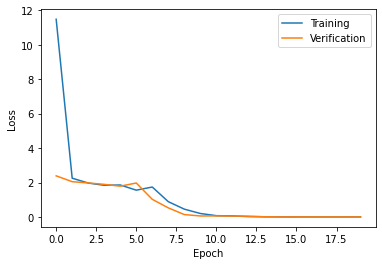

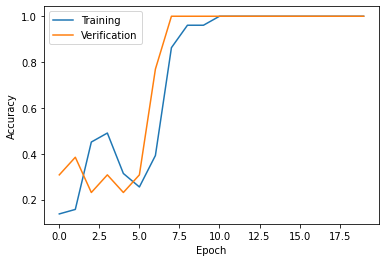

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.2432214617729187; accuracy of 100.0%
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.0005467242444865406; accuracy of 100.0%
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.00021258616470731795; accuracy of 100.0%
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.04106396064162254; accuracy of 100.0%
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 4.569680243093899e-07; accuracy of 100.0%
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecate

[35, 33, 34, 32, 31, 30, 29, 28, 2, 27, 26, 23, 25, 24, 22, 21, 20, 18, 19, 1, 17, 14, 15, 16, 13, 12, 11, 10, 9, 0, 70, 6, 69, 71, 68, 67, 66, 65, 64, 63, 59, 62, 60, 61, 5, 58, 57, 56, 55, 54, 53, 52, 50, 49, 51, 48, 4, 46, 47, 45, 44, 41, 42, 43, 40, 39, 3, 36, 38, 37, 78, 8, 7, 79, 77, 76, 75, 74, 73, 72]
[3 1 3 4 0 7 4 2 1 4 2 2 3 7 1 0 1 6 2 0 4 0 5 7 1 4 1 1 2 6 1 4 3 2 6 2 3
 2 1 6 2 3 0 0 1 4 4 1 1 2 3 3 3 2 3 4 0 2 2 1 2 3 6 1 6 1 1 0 3 2 6 4 1 3
 0 2 0 1 5 2]


In [18]:
# [6] 학습 및 성능 분석
from sklearn.model_selection import KFold

def main():
  # 파라미터 설정
  # Nin 입력 계층 노드 수, number_of_class 출력값이 가질 클래스 수, Nout 출력 노드 수
  Nin = 784
  number_of_class = 8
  Nout = number_of_class

  # 모델 설정
  model = CNN_seq_func(144, 144, Nout)
  (X_train, Y_train), (X_test, Y_test) = Data_func()

  # 학습하기(cross_validation 필요)
  history = model.fit(X_train, Y_train, epochs=20, batch_size=20, validation_split=0.2)
  performance_test = model.evaluate(X_test, Y_test, batch_size=20)
  print('Test Loss -->', performance_test[0])
  print('Test Accuracy -->', performance_test[1])
  print('Test Precision -->', performance_test[2])
  print('Test Recall -->', performance_test[3])
  print('Test F1-score -->', performance_test[4])

  plot_loss(history)
  plt.show()
  plot_acc(history)
  plt.show()

  # 교차 검증
  
  # Define per-fold score containers
  acc_per_fold = []
  loss_per_fold = []
  # cross validation
  # Define the K-fold Cross Validator
  kfold = KFold(n_splits=5, shuffle=True)

  # K-fold Cross Validation model evaluation
  fold_no = 1

  for train, test in kfold.split(X_train, Y_train):

    # Define the model architecture
    model = CNN_seq_func(144, 144, Nout)

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model.fit(X_train[train], Y_train[train],
                        batch_size=20,
                        epochs=20,
                        verbose=0)

    # Generate generalization metrics
    scores = model.evaluate(X_train[test], Y_train[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1

  # == Provide average scores ==
  print('------------------------------------------------------------------------')
  print('Score per fold')
  for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
  print('------------------------------------------------------------------------')
  print('Average scores for all folds:')
  print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
  print(f'> Loss: {np.mean(loss_per_fold)}')
  print('------------------------------------------------------------------------')

  # csv 결과 제출용

  test_dir = './drive/MyDrive/01_finger_test'
  file_list = os.listdir(test_dir)

  dataset = []
  names = []
  W = 144
  H = 144
  for file in file_list:
    name = file.split('.')[0]
    data = imread(test_dir+"/"+file)
    data = imresize(data, (144,144))
    dataset.append(data)
    names.append(int(name)-1)

  dataset = np.asarray(dataset)
  dataset = dataset.astype('float32')

  dataset = dataset.reshape(-1,W,H,1)
  dataset = dataset / np.max(dataset) # 정규화: 0~255로 되어 있는 입력값을 0~1로 바꿔줌(성능 최적화를 위함)

  y = model.predict_classes(dataset)
  print(names)
  print(y)

# main() 코드 실행하기
if __name__ == '__main__':
  main()